In [ ]:
#This algorithm refers to the RLS algorithm for PPG by C.Wu.
#It is written mainly by my supervisor Kunal.
#Unfinished code

In [ ]:
# # Code to read csv file into Colaboratory:
# from google.colab import drive
# drive.mount('/content/gdrive')

#url = 'https://raw.githubusercontent.com/KG-PHD/John/master/01_A_GSR.csv?token=ALV4T6QIMVRK3SGXIJICOM27K425I'
url = 'https://raw.githubusercontent.com/KG-PHD/John/master/physio/s2_high_resistance_bike.csv'

# url = 'https://raw.githubusercontent.com/KG-PHD/John/master/data/shimmerBaseline.csv'



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import biosppy
import os
import padasip as pa
from sklearn.metrics import mean_squared_error
import  peakutils

In [ ]:
# df = pd.read_csv('01_A_GSR.csv')
plt.style.use('seaborn')
df = pd.read_csv(url)
df = df.drop(df.index[0]) #removes units
df = df.reset_index(drop=True)
print(df.columns)


Index([''Elapsed time'', ''chest_ecg'', ''wrist_ppg'', ''wrist_gyro_x'',
       ''wrist_gyro_y'', ''wrist_gyro_z'', ''wrist_low_noise_accelerometer_x'',
       ''wrist_low_noise_accelerometer_y'',
       ''wrist_low_noise_accelerometer_z'',
       ''wrist_wide_range_accelerometer_x'',
       ''wrist_wide_range_accelerometer_y'',
       ''wrist_wide_range_accelerometer_z'', ''wrist_mag_x'', ''wrist_mag_y'',
       ''wrist_mag_z'', ''sample_times_for_all_signals_apart_from_ecg''],
      dtype='object')


In [ ]:
# Time = df['timestamp'].astype(np.float64)
# XShimmer = df['ACCEL_X'].astype(np.float64)
# YShimmer = df['ACCEL_Y'].astype(np.float64)
# ZShimmer = df['ACCEL_Z'].astype(np.float64)
# PPG = df['PPG_RAW'].astype(np.float64)
# print(len(PPG))

In [ ]:
#Time = df["'Elapsed time'"]
Time = df["'Elapsed time'"]
XShimmer = df["'wrist_wide_range_accelerometer_x'"].astype(np.float64)
#XShimmer = df['X (Shimmer)']
#YShimmer = df['Y (Shimmer)']
YShimmer = df["'wrist_wide_range_accelerometer_y'"].astype(np.float64)
#ZShimmer = df['Z (Shimmer)']
ZShimmer = df["'wrist_wide_range_accelerometer_z'"].astype(np.float64)
#SkinConductance = df['Skin Conductance']
#SkinResistance = df['Skin Resistance']
PPG = df["'wrist_ppg'"].astype(np.float64)
#PPG = df["PPG"]
#HRV = df['HRV']
#HeartRate = df['Heart Rate']
#GyroP = df['Gyro P (Shimmer)']
#GyroR = df['Gyro R (Shimmer)']
#GyroY = df['Gyro Y (Shimmer)']

In [ ]:
df["'wrist_ppg'"] =df["'wrist_ppg'"].astype(np.float64)
df.dtypes
print(len(PPG))

15360


In [ ]:
def normalize(a):
    o = [None]*len(a)
    m = min(a)
    M = max(a)
    for i in range(len(a)):
        o[i]=(a[i] - m)/(M-m)
        
    return o

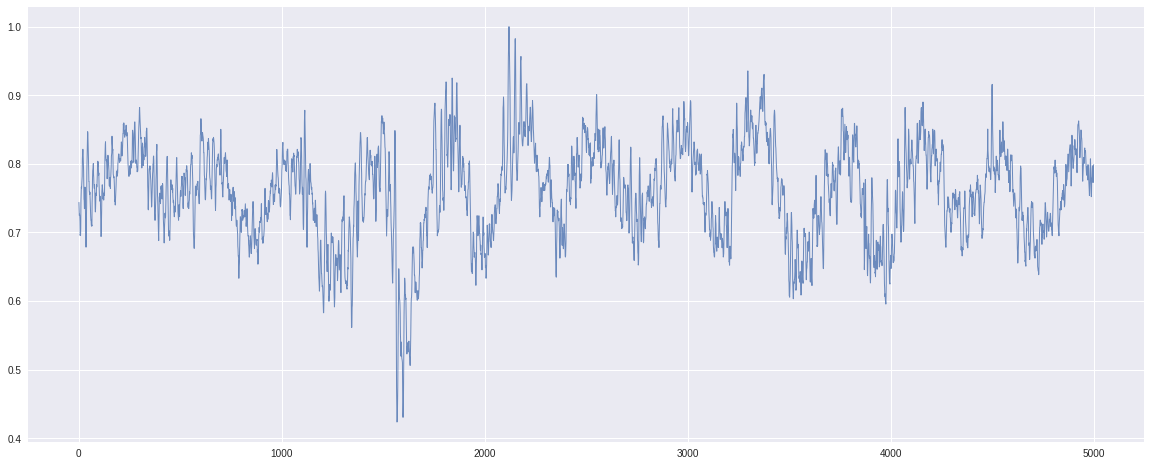

In [ ]:
a = PPG.values.flatten()
b = XShimmer.values.flatten()
c = YShimmer.values.flatten()
d = ZShimmer.values.flatten()

a = normalize(a)
b = normalize(b)
c = normalize(c)
d = normalize(d)

acc_x = b
acc_y = c
acc_z = d
plt.figure(figsize=(20,8))
# plt.plot(a[:5000], color='b', marker='o', linestyle='', markersize=5)
# plt.plot(b[:5000], color='r', marker='o', linestyle='', markersize=5 )
# plt.plot(c, lw=0.8, alpha=0.8 )
# plt.plot(a[0:5000],lw=1,alpha=0.8)
plt.plot(acc_x[0:5000], lw=1, alpha=0.8 )
# plt.plot(acc_y[0:5000], lw=1, alpha=0.8 )

Butterworth IIR Filter

In [ ]:
fs = 128  # Sampling frequency
# Generate the time vector properly
t = len(PPG) / fs
print(t)

120.0


In [ ]:
#Converting  to Numpy

# ppg = PPG.to_numpy()
# x_shim = XShimmer.to_numpy()
# print(ppg)


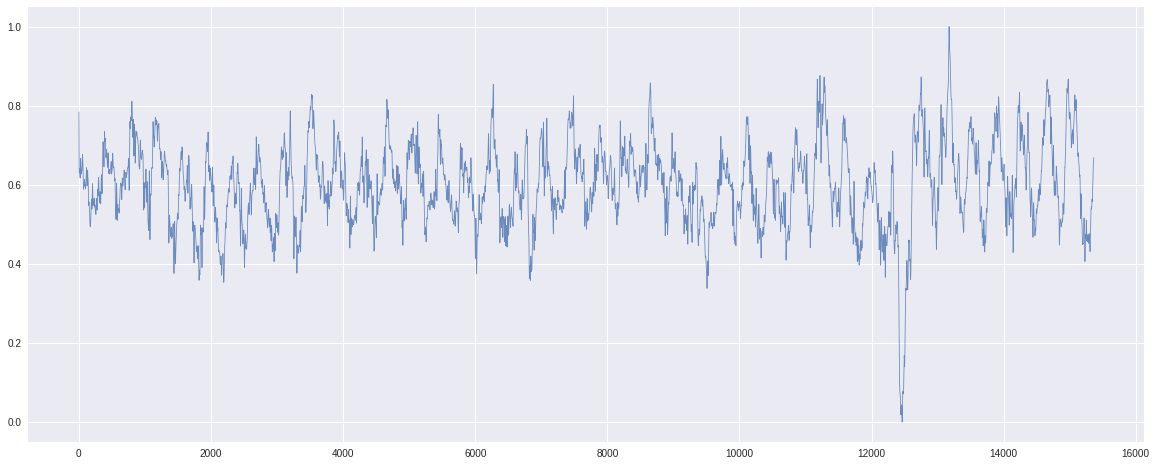

In [ ]:
# ppg_norm =normalize(ppg)
plt.figure(figsize=(20,8))
plt.plot(a, lw=0.8, alpha=0.8)

In [ ]:
#DC Blocker

def dc_block(ppg,a):
    x = [None]*len(ppg)
    w = [None]*len(ppg)
    y = [None]*len(ppg)
    
    for i in range(len(ppg)):
        if(i==0):
            x[0] = ppg[0]
            w[0] = x[0]
            y[0] = 0
        else:
            x[i] = ppg[i]
            w[i] = x[i] + a*w[i-1]
            y[i] = w[i]-w[i-1]
        
    return y

In [ ]:
# y_low_norm = dc_block(ppg_norm,0.05)
# y_high_norm = dc_block(ppg_norm,0.9)
# y_low = dc_block(ppg, 0.2)
# y_high = dc_block(ppg,0.9)

y_low_norm = dc_block(a,0.05)
y_high_norm = dc_block(a,0.9)
y_low = dc_block(a, 0.2)
y_high = dc_block(a,0.9)

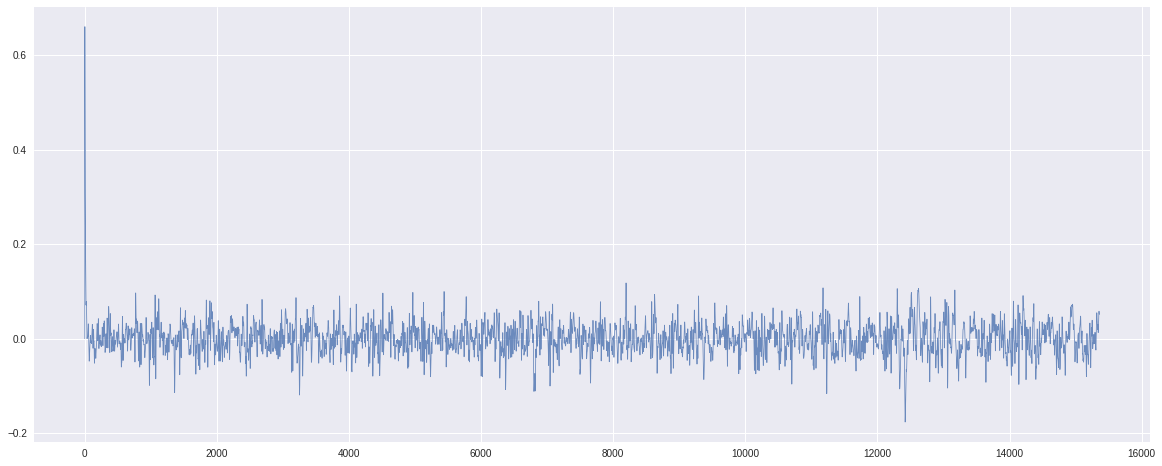

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(y_high_norm, lw=0.8, alpha=0.8)

In [ ]:
y_high_norm=np.array(y_high_norm)

index = peakutils.indexes(y_high_norm, thres=0.2, min_dist=27)
print(len(index))

350


# RLS Algorithm

s(t) = s'(t) - n(t)

n(t) = (t,k=0)SUM{w(k) * x(k)} = TRANSPOSE(theta) * thi

s'(t) = AC_ppg

n(t) = active noise

w(k) = filter coefficients

x(k) = accelerometer data

theta = TRANSPOSE([ w1, w2, w3,...,wn])

phi = TRANSPOSE([x(t-n),x(t-n+1),...,x(t)])

Setting up vectors for filter coefficient(theta) and accelerometer reference(phi)


In [ ]:
theta = []
phi = []
n = []
filt_ppg =[]
for i in range(len(XShimmer)):
    if i < 10:
        theta = np.zeros(i+1)
        phi = np.zeros(i+1)
        for x in range(i+1):
            phi[x] = XShimmer[x]
        #insert coefficient update here
    else:
        theta =np.zeros(10)
        phi = np.zeros(10)
        for x in range(10):
            phi[x] = XShimmer[i-9+x]
        #insert coefficient update here
    n = theta.dot(phi)
    filt_ppg.append(ppg[i] - n)

print(filt_ppg)

NameError: ignored

Formula for padasip code vs research paper conversion

y(k) = x.T(k) * w(k)  ==  n(t) = theta.T * thi

w(k+1) = w(k) + Δw(k)  ==  theta(t) = theta(t-1) + b * (s(t) - n(t))

Δw(k) = R(k) * x(k) * e(k) == ??

??                         ==  b = (P(t-1) * thi(t))/(1 + thi(t) * P(t-1) * thi.T(t))

R(k) = (1/mu) * (R(k-1) - (R(k-1) * x(k) * x.T(K) * R(k-1))/ (mu + x.T(k) * R(k-1) * x(k))) ==

P(t) = (P(t-1) - (P(t-1) * thi(t) * thi.T(t) * P(t-1))/ (1 + thi(t) * P(t-1) * thi.T(t)))

e(k) = error
R(0) = identity matrix

In [ ]:
f = pa.filters.FilterRLS(n=10, mu=0.99, eps = 0.1, w='zeros')

# y,e,w = f.run(y_high_norm,XShimmer)

In [ ]:
print(len(y_high_norm), len(acc_y))

In [ ]:
# y,e,w = f.run(y_high_norm,XShimmer)
print(len(y_high_norm))

a = y_high_norm

15360


Trying a different Approach

Streaming output truncated to the last 5000 lines.
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
10505
10506
10507
10508
10509
10510
10511
10512
10513
10514
10515
10516
10517
10518
10519
1

IndexError: ignored

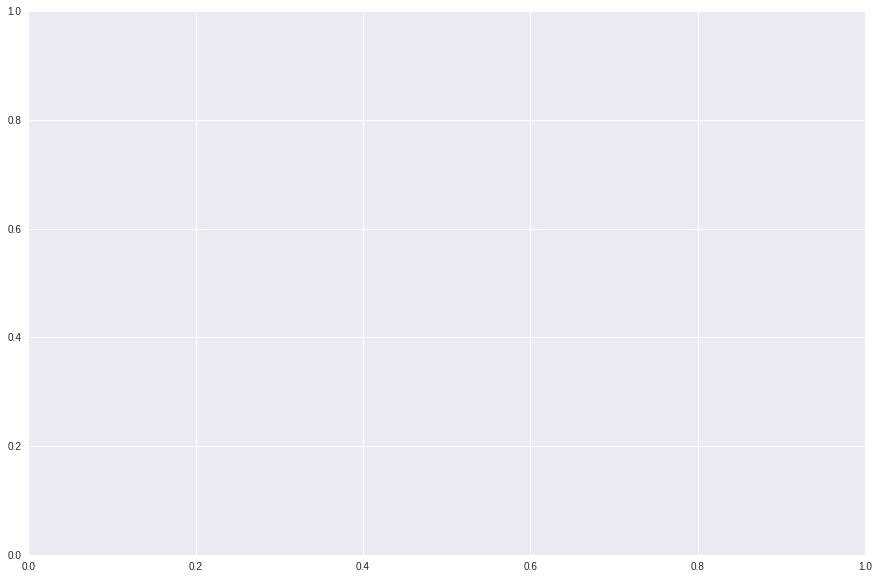

In [ ]:
llim = 0
ulim = 25000
step_size = 640
test_lim = 100
mu = [0.9966]
# 0.0001, 0.01, 0.0333, 0.5, 0.9888,  
error_mu = []
output = []
plt.figure(figsize=[15,10])
plt.ylim(0,1)

for m in mu:
  error = []
  f = pa.filters.FilterRLS(n=2,mu=m,w="random",eps=0.7)
  for k in range(llim, ulim, step_size):
    for i in range(k,k+step_size):
      print(i)
      f.adapt(b[i],np.array([1,a[i]]))
      
      # output.append(f.y)
    yhat = []
    for i in range(k+test_lim):
      yhat.append(np.dot(f.w, np.array([1,b[i]])))
    yhat = np.array(yhat)
    error.append(mean_squared_error(b[:k+test_lim],yhat)/test_lim)
  error = np.array(error)
  error_mu.append(error)
  # output = np.array(output)
  plt.plot(error,label="mu = {}".format(m),linewidth=3)
  
  plt.axis([0,40,0,0.004])
  print("mu = {} completed".format(m))
plt.legend(loc='upper right')

In [ ]:
plt.figure(figsize=[15,5])
plt.plot(acc, lw=0.8, alpha=0.8 )

NameError: ignored

<Figure size 1080x360 with 0 Axes>